In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

This code corresponds to our Empirical results section. The data (and zip file) is too large to store on Github but can be accessed online at: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home. In particular, we use the files pertaining to the "English review subset for spoiler
detection” (genre goodreads_reviews_spoiler.json) and “Extracted fuzzy book genre" (goodreads_book_genres_initial.json.)

# Construct Ratings Matrix

In [4]:
# load data
df = pd.read_json('goodreads_reviews_spoiler.json',lines=True)
df_genre = pd.read_json('goodreads_book_genres_initial.json',lines=True)
df_genre.head()

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


In [5]:
# merge datasets so that we can get the fuzzy genre tags for all of the books
merged_df = pd.merge(df, df_genre, on='book_id', how='left')
merged_df = merged_df[['rating', 'book_id', 'user_id', 'genres']]
merged_df.head()

,rating,book_id,user_id,genres
0,5,18245960,8842281e1d1347389f2ab93d60773d4d,"{'fiction': 393, 'fantasy, paranormal': 341, '..."
1,3,16981,8842281e1d1347389f2ab93d60773d4d,"{'fiction': 3501, 'history, historical fiction..."
2,3,28684704,8842281e1d1347389f2ab93d60773d4d,"{'fiction': 3969, 'mystery, thriller, crime': ..."
3,0,27161156,8842281e1d1347389f2ab93d60773d4d,"{'non-fiction': 4371, 'history, historical fic..."
4,4,25884323,8842281e1d1347389f2ab93d60773d4d,"{'fiction': 1108, 'fantasy, paranormal': 132}"


In [6]:
# create indicators for each of the genres 
def create_genre_indicators(genre_dict):
    indicators = {}
    for genre in genre_dict.keys():
        genres = genre.split(':')
        genre_name = genres[0].strip().strip("'\"")
        indicators[genre_name] = 1
    return indicators
    
# Apply the function to the 'genres' column and expand the dictionary into separate columns
genre_indicators = merged_df['genres'].apply(create_genre_indicators).apply(pd.Series).fillna(0)
genre_indicators = genre_indicators[genre_indicators.sum().sort_values(ascending=False).index] # sort by popularity
genre_indicators.head()

,fiction,romance,young-adult,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",children,"comics, graphic",non-fiction,poetry
0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Construct ratings matrix (user_genre_counts)
df = pd.concat([merged_df, genre_indicators], axis=1)
df = df.drop(columns=['genres', 'book_id', 'rating', "fiction"]) # we remove fiction which encompasses most of the other genres
df = df.groupby('user_id').sum().reset_index()
user_genre_counts = df.drop(columns=['user_id'])
user_genre_counts.head()

,romance,young-adult,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",children,"comics, graphic",non-fiction,poetry
0,171.0,134.0,118.0,103.0,14.0,5.0,1.0,1.0,1.0
1,76.0,25.0,9.0,20.0,2.0,1.0,0.0,1.0,0.0
2,2.0,2.0,5.0,7.0,5.0,0.0,1.0,3.0,1.0
3,17.0,2.0,1.0,6.0,4.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# MAKE A SORTED RATINGS MATRIX
genre_totals = user_genre_counts.sum().sort_values(ascending=False)

# rank the popular genres
temp = user_genre_counts[genre_totals.index]
genre_popularity_rank = genre_totals.rank(ascending=False, method='first')

# sort users by popularity of their favorite genre
user_genre_counts['favorite_genre'] = user_genre_counts.idxmax(axis=1)
user_genre_counts["genre_popularity_rank"] = user_genre_counts["favorite_genre"].map(genre_popularity_rank)
user_genre_counts = user_genre_counts.sort_values(by="genre_popularity_rank").reset_index(drop=True)

# save the list of popular genres 
genres_ordered_by_popularity = genre_popularity_rank.sort_values().index.tolist()
genres_ordered_by_popularity

# create a numeric ratings matrix
sorted_ratings_matrix = user_genre_counts.drop(columns=["genre_popularity_rank", "favorite_genre"])
R = sorted_ratings_matrix
m,n = R.shape[0], R.shape[1]
genres = R.columns.to_list()

# Here is R
R.head()

,romance,young-adult,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",children,"comics, graphic",non-fiction,poetry
0,171.0,134.0,118.0,103.0,14.0,5.0,1.0,1.0,1.0
1,64.0,60.0,53.0,38.0,36.0,17.0,2.0,3.0,0.0
2,30.0,27.0,21.0,17.0,9.0,0.0,0.0,1.0,0.0
3,134.0,18.0,47.0,48.0,5.0,0.0,0.0,0.0,0.0
4,160.0,135.0,44.0,50.0,2.0,0.0,0.0,0.0,4.0


# Tables and Figures

In [10]:
# Code for Table: Popularity of Book Genres by Number of Users and Total Reviews

favorite_counts = user_genre_counts['favorite_genre'].value_counts()
total_rating = R.sum(axis=0)

summary_df = pd.DataFrame({
    'Number of Users (Favorite)': favorite_counts,
    'Total Rating (Thousands)': np.round(total_rating/1000)
}).fillna(0).astype({'Number of Users (Favorite)': int})

summary_df.rename(columns={'index': 'Genre'}, inplace=True)

summary_df

,Number of Users (Favorite),Total Rating (Thousands)
children,3,114.0
"comics, graphic",12,71.0
"fantasy, paranormal",4427,823.0
"history, historical fiction, biography",668,320.0
"mystery, thriller, crime",1087,650.0
non-fiction,7,47.0
poetry,0,14.0
romance,7627,1044.0
young-adult,5061,869.0


m=18892 and n=9
Singular Values 1 and 2 are: (22453.0, 4948.0)


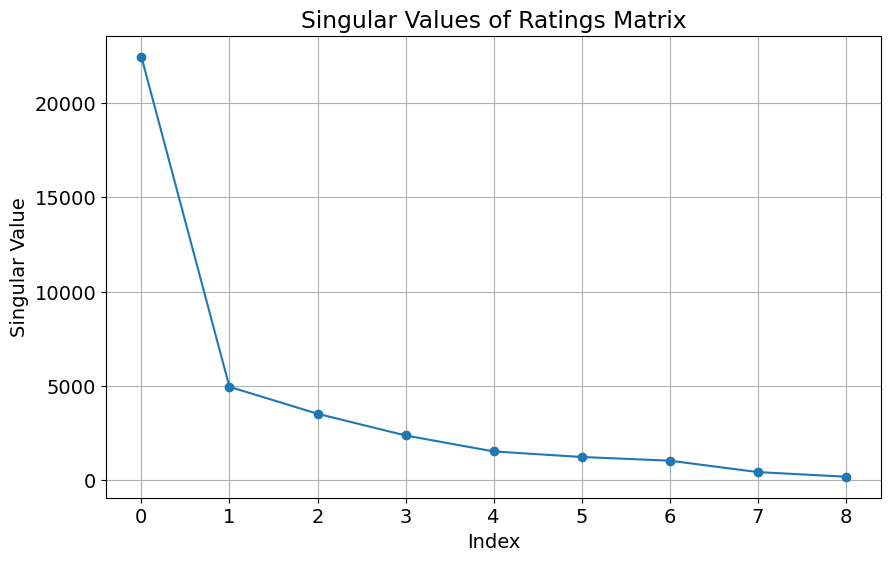

In [11]:
# Code for Figure: Plot of Singular Values for Goodreads Ratings Matrix

best_items = np.argmax(R, axis=1)
m,n = R.shape[0], R.shape[1]
print(f'm={m} and n={n}')
U, S, VT = np.linalg.svd(R, full_matrices=False)
print(f"Singular Values 1 and 2 are: {(np.round(S[0]), np.round(S[1]))}")
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6))
plt.plot(S, marker='o')
plt.title('Singular Values of Ratings Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.savefig('figures/singular_values.png')
plt.show()

Statistics for 1/2 Romance Users and Genre Children
Percent Welfare Change: 9.4
Singular Value 2 is 5447.0

Statistics for 1/2 Romance Users and Genre Comics and Graphic
Percent Welfare Change: 7.9
Singular Value 2 is 5609.0

Statistics for 1/2 Romance Users and Genre Non-fiction
Percent Welfare Change: 9.3
Singular Value 2 is 5797.0



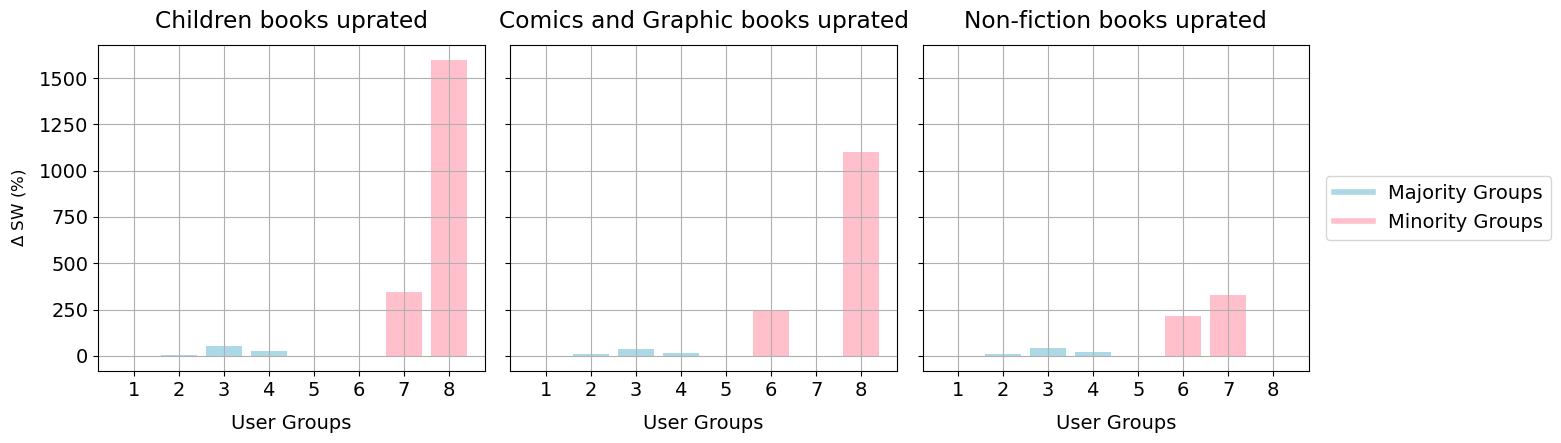

Statistics for 1/3 Romance Users and Genre Children
Percent Welfare Change: 9.5
Singular Value 2 is 4976.0

Statistics for 1/3 Romance Users and Genre Comics and Graphic
Percent Welfare Change: 9.5
Singular Value 2 is 5039.0

Statistics for 1/3 Romance Users and Genre Non-fiction
Percent Welfare Change: 9.8
Singular Value 2 is 5185.0



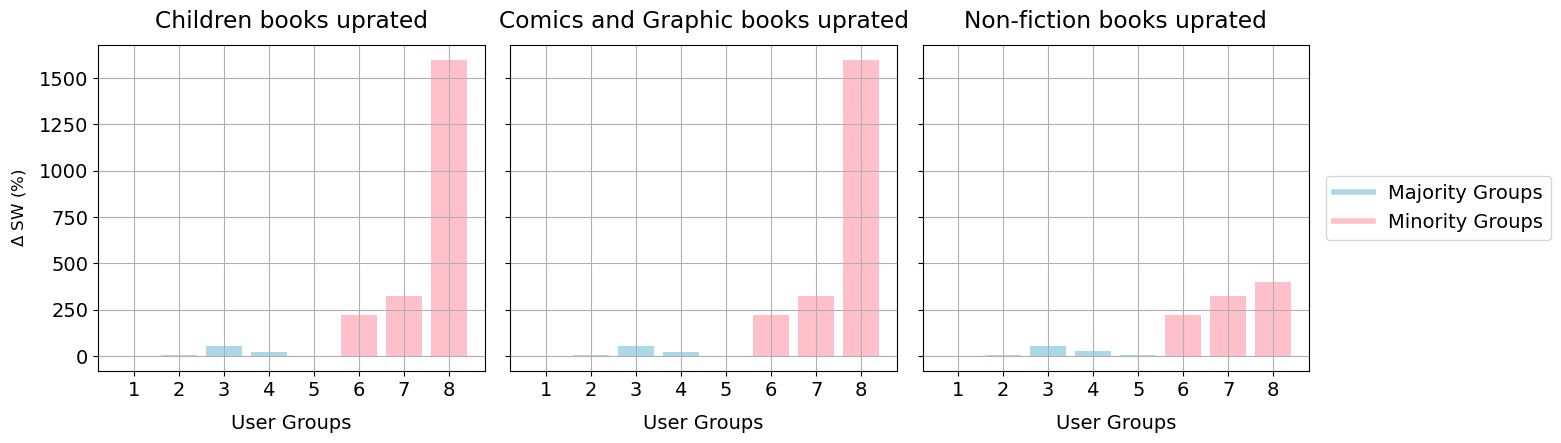

In [12]:
# Code for 
# 1) Figure: Altruism Welfare Improvements by Genre Group (Romance Users Uprating)
# 2) Table: Percent Total Social Welfare Improvement for Different EA Strategies
# 3) Table: Singular Value Gap for Different EA Strategies



# General Functions to Compute REPORTED R, and do the learner's problem 

# Create R_Tilde
def create_R_tilde(R, items, i_star, fraction):
    
    R_tilde = np.copy(R)  # start with a copy of R
    
    for u in range(R.shape[0]):        # for each user
        for i in range(R.shape[1]):    # for each item
            if items[u] in {0}:
                    if u % fraction ==1:
                        if i == i_star:
                            R_tilde[u, i] = 2 * R.iloc[u, items[u]] / 3
            else:
                R_tilde[u, i] = R.iloc[u, i]
    
    return R_tilde
    
def alpha_loss_learner(alpha, U, S, VT):
    
    k = next((i for i, s in enumerate(S[1:], start=1) if s <= alpha), len(S))
    U_k = U[:, :k]            # (n x k)
    S_k = np.diag(S[:k])      # (k x k)
    VT_k = VT[:k, :]          # (k x m)

    # Reconstruct the matrix using the first k components
    approx_matrix = U_k @ S_k @ VT_k
    return approx_matrix, k

def get_sw_values(R, items):
    sw_values = []
    m = R.shape[0]
    for u in range(m):
        i_u = items[u]
        rating = R.iloc[u,i_u]
        sw_values.append(rating)
    return sw_values
    
# Labeled Names of Genres For Plotting
genres_short = ['Romance',
 'Young-Adult',
 'Fantasy',
 'Mystery',
 'History',
 'Children',
 'Comics and Graphic',
 'Non-fiction',
 'Poetry']

def solve_EA_system_comparison(fractions, genres_to_uprate):
    num_rows = len(fractions)
    num_cols = len(genres_to_uprate)
    fig, axes = plt.subplots(num_rows, num_cols,
                             figsize=(6 * num_cols, 5 * num_rows),
                             sharex=True, sharey=True)

    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    x_indices = np.arange(1,len(genres))

    for row_idx, fraction in enumerate(fractions):
        for col_idx, i_star in enumerate(genres_to_uprate):
            ax = axes[row_idx, col_idx]

            # Compute and plot welfare changes 
            R_tilde = create_R_tilde(R, best_items, i_star, fraction)
            U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)
            singular_value_gap = S_tilde[1] - S[1]
            alpha = S[1] + singular_value_gap / 2

            R_hat, k = alpha_loss_learner(alpha, U, S, VT)
            rec_items = np.argmax(R_hat, axis=1)

            R_hat_tilde, k_tilde = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
            rec_items_EA = np.argmax(R_hat_tilde, axis=1)

            SW_genre_change = np.zeros(len(genres) - 1)
            total_change = 0
            total_welfare = 0
            for i in range(len(genres) - 1):
                total, change = 0, 0
                for u in range(m):
                    if best_items[u] == i:
                        change += R.iloc[u, rec_items_EA[u]] - R.iloc[u, rec_items[u]]
                        total += R.iloc[u, rec_items[u]]
                SW_genre_change[i] = (change / total * 100) if total != 0 else 0
                total_change += change
                total_welfare += total
            print(f"Statistics for 1/{fraction} Romance Users and Genre {genres_short[i_star]}")
            print(f"Percent Welfare Change: {np.round(100*total_change/total_welfare,1)}")
            print(f"Singular Value 2 is {np.round(S_tilde[1])}")
            print()

            colors = ['lightblue' if idx < 5 else 'pink'
                      for idx in range(len(genres)-1)]

            ax.bar(x_indices, SW_genre_change, color=colors)

            # Remove titles from bottom row plots
            if row_idx == 0:
                ax.set_title(f'{genres_short[i_star]} books uprated', pad=12)

            ax.grid(True)

            # Only set y-label for first column plots
            if col_idx == 0:
                ax.set_ylabel('$\\Delta$ SW (%)', fontsize=12, labelpad=8)

            # Only add x-axis label on bottom row plots
            if row_idx == num_rows - 1:
                ax.set_xlabel('User Groups', labelpad=10)
                ax.set_xticks(x_indices)
            else:
                ax.set_xticks(x_indices)
                ax.set_xticklabels([''] * len(x_indices))
                ax.set_xlabel('')  

    # Custom legend placed outside plots
    legend_elements = [
        plt.Line2D([0], [0], color='lightblue', lw=4, label='Majority Groups'),
        plt.Line2D([0], [0], color='pink', lw=4, label='Minority Groups')
    ]
    axes[0, -1].legend(handles=legend_elements,
                       loc='center left', bbox_to_anchor=(1.02, 0.5))

    # Adjust subplot spacing carefully
    plt.subplots_adjust(hspace=0.3, wspace=0.15)

    fig.tight_layout(rect=[0, 0, 0.88, 0.93])

    plt.savefig(f'figures/romance_users_uprating_{fraction}.png', bbox_inches='tight')
    plt.show()

genres_to_uprate = [5,6,7]
solve_EA_system_comparison([2], genres_to_uprate)
solve_EA_system_comparison([3], genres_to_uprate)